In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from concepts import concept_instances
from sk_probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [4]:
game_data = load_game_data()

max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layer = 5

In [5]:
q_network, device = load_q_network_device()
q_network.to('cpu')

QNetwork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [6]:
concept_cavs = {}
for concept in concept_instances.values():
    concept.prepare_data(game_data)
    probe, score = train_probe(q_network, concept, layer, max_iter, k_fold, num_reg)
    if concept.binary:
        cav = probe.coef_[0]
    else:
        cav = probe.coef_
    concept_cavs[concept.name] = cav
    print(f"{concept.name:^35} | {score:^10.4f}")

              ball y                |   0.4923  
              ball x                |   0.8432  
           ball low (b)             |   0.9804  
        ball collision (b)          |   0.7688  
       ball going right (b)         |   0.7765  
        ball going left (b)         |   0.8282  
         ball going up (b)          |   0.9171  
        ball going down (b)         |   0.8945  
            ball speed              |   0.4159  
             paddle x               |   0.9751  
     ball left for paddle (b)       |   0.8251  
     ball right for paddle (b)      |   0.7733  
       ball above paddle (b)        |   0.6445  
       ball paddle distance         |   0.7479  
               lives                |   0.6815  
           last life (b)            |   0.9841  
          losing life (b)           |   0.9890  
            random (b)              |  -0.0067  
           brick hit (b)            |   0.8824  
            bricks hit              |   0.9925  


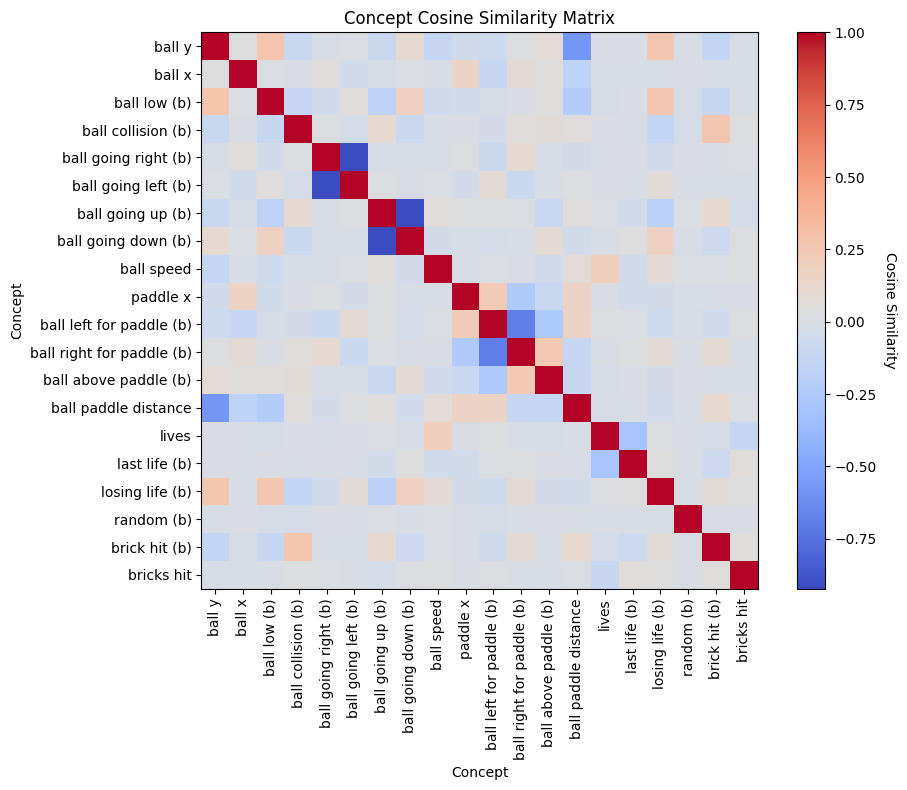

In [7]:
num_concepts = len(concept_cavs)
similarity_matrix = np.zeros((num_concepts, num_concepts))

# Populate the matrix
for i, concept1 in enumerate(concept_cavs):
    for j, concept2 in enumerate(concept_cavs):
        similarity_matrix[i, j] = cosine_similarity(concept_cavs[concept1], concept_cavs[concept2])

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
# set x and y labels
plt.xlabel('Concept')
plt.ylabel('Concept')
cbar = plt.colorbar()
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15)
plt.title('Concept Cosine Similarity Matrix')
plt.xticks(np.arange(num_concepts), concept_cavs.keys(), rotation=90)
plt.yticks(np.arange(num_concepts), concept_cavs.keys())
plt.tight_layout()
plt.savefig('../figures/concept_similarity.png', dpi=300)
plt.show()

In [8]:
pairs_with_scores = []
for i, concept1 in enumerate(concept_instances.keys()):
    for j, concept2 in enumerate(concept_instances.keys()):
        if i < j:  # No duplicate pairs
            similarity = cosine_similarity(concept_cavs[concept1], concept_cavs[concept2])
            pairs_with_scores.append(((concept1, concept2), similarity))

# Sort pairs based on similarity
sorted_pairs = sorted(pairs_with_scores, key=lambda x: x[1], reverse=True)

# Extract top x and bottom x correlated concept pairs
x = 10
top_x_concepts = sorted_pairs[:x]
bottom_x_concepts = sorted_pairs[-x:]

print(f"Top {x} Correlated Concepts:\n")
print(f"{'Concept 1':^40} | {'Concept 2':^40} | {'Score':^10}")
print('-' * 100)
for (pair, score) in top_x_concepts:
    print(f"{pair[0]:^40} | {pair[1]:^40} | {score:^10.4f} |")

print(f"\nBottom {x} Correlated Concepts:\n")
print(f"{'Concept 1':^40} | {'Concept 2':^40} | {'Score':^10}")
print('-' * 100)
for (pair, score) in bottom_x_concepts:
    print(f"{pair[0]:^40} | {pair[1]:^40} | {score:^10.4f} |")
    

Top 10 Correlated Concepts:

               Concept 1                 |                Concept 2                 |   Score   
----------------------------------------------------------------------------------------------------
                 ball y                  |               ball low (b)               |   0.2733   |
           ball collision (b)            |              brick hit (b)               |   0.2670   |
              ball low (b)               |             losing life (b)              |   0.2628   |
                 ball y                  |             losing life (b)              |   0.2577   |
       ball right for paddle (b)         |          ball above paddle (b)           |   0.2363   |
                paddle x                 |         ball left for paddle (b)         |   0.2196   |
               ball speed                |                  lives                   |   0.2026   |
              ball low (b)               |           ball going down (b)        